In [6]:
!pip install yfinance

  Obtaining dependency information for yfinance from https://files.pythonhosted.org/packages/1b/0f/77716aa9dd84bb1aa5e93c87122af1de89697b6231f6d01d58d4e7c03c14/yfinance-0.2.36-py2.py3-none-any.whl.metadata
  Using cached yfinance-0.2.36-py2.py3-none-any.whl.metadata (11 kB)
  Using cached multitasking-0.0.11-py3-none-any.whl (8.5 kB)
  Using cached frozendict-2.4.0-py3-none-any.whl
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
      --------------------------------------- 0.0/3.0 MB 326.8 kB/s eta 0:00:09
     - -------------------------------------- 0.1/3.0 MB 525.1 kB/s eta 0:00:06
     - -------------------------------------- 0.1/3.0 MB 525.1 kB/s eta 0:00:06
     --- ------------------------------------ 0.2/3.0 MB 860.2 kB/s eta 0:00:04
     --- ------------------------------------ 0.2/3.0 MB 838.1 kB/s eta 0:00:04
  

In [1]:
import yfinance as yf
sp500=yf.Ticker("^GSPC")

In [2]:
sp500=sp500.history(period="max")

In [3]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-02-09 00:00:00-05:00,5004.169922,5030.060059,5000.339844,5026.609863,3912990000,0.0,0.0
2024-02-12 00:00:00-05:00,5026.830078,5048.390137,5016.830078,5021.839844,3805740000,0.0,0.0
2024-02-13 00:00:00-05:00,4967.939941,4971.299805,4920.310059,4953.169922,4302190000,0.0,0.0


<Axes: xlabel='Date'>

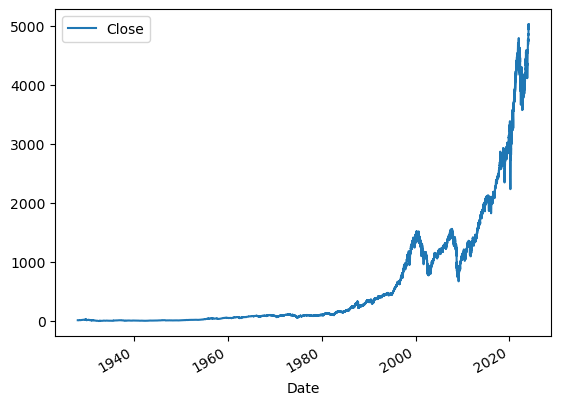

In [4]:
sp500.plot.line(y="Close", use_index=True)

In [5]:
sp500["Tomorrow"]=sp500["Close"].shift(-1)

In [6]:
sp500["Target"] = (sp500["Tomorrow"]>sp500["Close"]).astype(int)

In [7]:
sp500=sp500.loc["1990-01-01":].copy()

In [8]:
!pip install scikit-learn
import pandas as pd

In [9]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [10]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5609756097560976

<Axes: xlabel='Date'>

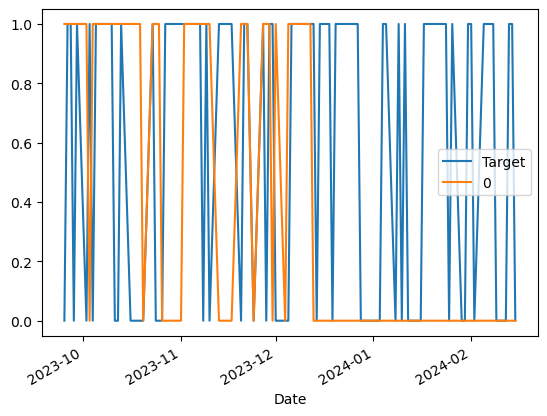

In [11]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [12]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [13]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [14]:
predictions = backtest(sp500, model, predictors)


In [15]:
predictions["Predictions"].value_counts()

Predictions
0    3501
1    2596
Name: count, dtype: int64

In [16]:
precision_score(predictions["Target"], predictions["Predictions"])


0.5288906009244992

In [17]:
predictions["Target"].value_counts() / predictions.shape[0]


Target
1    0.534853
0    0.465147
Name: count, dtype: float64

In [18]:
horizons = [2,5,50,100,200,250,500,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [19]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])


In [20]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)


In [36]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.7] = 1
    preds[preds <.7] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [37]:
predictions = backtest(sp500, model, new_predictors)

In [38]:
predictions["Predictions"].value_counts()


Predictions
0.0    5086
1.0      11
Name: count, dtype: int64

In [39]:
precision_score(predictions["Target"], predictions["Predictions"])


0.7272727272727273

In [40]:
predictions["Target"].value_counts() / predictions.shape[0]


Target
1    0.544634
0    0.455366
Name: count, dtype: float64